In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the seed for reproducibility
SEED = 1237
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 24  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 768  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'full'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = True  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=24,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)


In [19]:
### used multi-label dataset

In [20]:
data_path = "C:/Users/Mai/thesis/ch 4/multilabel-dataset.csv" 
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Sentiment': 'sentiment'})

In [21]:
##data_df.head()

In [22]:
##groupedby_sentiment = data_df.groupby(data_df.sentiment)
##data_df_positive = groupedby_sentiment.get_group("Positive")
##data_df_positive

In [23]:
##data_df_negative = groupedby_sentiment.get_group("Negative")
##data_df_negative

In [24]:
##data_df_neutral = groupedby_sentiment.get_group("Neutral")
##data_df_neutral

In [25]:
## binary hate non-hate
##data_df_hate = data_df_negative.sample(n = 2560)

##data_df_positive = data_df_positive.sample(n = 2560)
##data_df_neutral = data_df_neutral.sample(n = 2560)

##data_df_nonhate = data_df_positive.append(data_df_neutral)

##data_df = data_df_hate.append(data_df_nonhate)

In [26]:
##data_df = data_df.drop(['Label'], axis = 1)

In [27]:
#data_df.to_csv('dataset.csv', index=False)
data_df

text sentiment     Label
0     Dictator's son on the cusp of power in the #Ph...  Negative      Hate
1     Kung ang definition ni BongBong Marcos sa isan...  Negative      Hate
2     Leni Robredo is not being subjected by her opp...  Negative      Hate
3     @imstillsour Tuwang tuwa sila sa Pink hahaha.....  Negative      Hate
4     Kapag hindi si VP Leni Robredo ang iboboto mo ...  Negative      Hate
...                                                 ...       ...       ...
7675   VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST   Neutral  Non-hate
7676  @alt_ego143 @rapplerdotcom @ramboreports hindi...   Neutral  Non-hate
7677  I can't vote yet, but my president is Leni Rob...   Neutral  Non-hate
7678  Anyways President Leni Robredo #SaveLegendsOfT...   Neutral  Non-hate
7679  Kung ayaw nyo d wag nyo iboto.Napaka simple.. ...   Neutral  Non-hate

[7680 rows x 3 columns]

In [28]:
##data_df = data_df.reset_index()

In [29]:
##data_df

In [30]:
# data_df = "dataset.csv"

In [31]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# Date De-Identification
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    
     # Use re.sub to replace mentions with a single space
    text = mention_pattern.sub(' ', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(text.split())
    
    return cleaned_text

# URL Removal
def remove_url (text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to replace URLs with a single space
    text = url_pattern.sub(' ', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(text.split())
    
    return cleaned_text

# Special Characters Removal
def remove_special_characters(text):
    # Remove emojis
    text = emoji.replace_emoji(text, replace="[emoji]")
    
    # Split the text into words
    words = text.split(" ")
    
    # Initialize an empty string to store the cleaned text
    cleaned_text = ""
    
    # Iterate through each word
    for word in words:
        # Check if the word contains only special characters or "[emoji]"
        if not (re.match(r"^[_\W]+$", word) or "[emoji]" in word):
            if len(cleaned_text) == 0:
                cleaned_text = f"{word}"
            else:
                cleaned_text = f"{cleaned_text} {word}"
    
    return cleaned_text

# Numerics Removal and Further Special Characters Removal
def remove_numerics(text):
    # Remove diacritics
    text_no_diacritics = unidecode.unidecode(text)

    # Split the text into words
    sentence = text_no_diacritics.split(" ")
    output = ""

    # Remove special characters and numerics
    for part in sentence:
        part = re.sub("[^A-Za-z ]+$", "", part)
        part = re.sub("^[^A-Za-z #]+", "", part)
        if not (len(part) <= 1 or re.match(r"[^a-zA-Z#]", part)):
            if len(output) == 0:
                output = f"{part}"
            else:
                output = f"{output} {part}"

    return output

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    return ' '.join(filtered_words)

# Candidate Name Removal
def remove_candidate_names(text):
    candidatelist = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
    candidatelist = candidatelist.split()
    candidate_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, candidatelist)) + r')\b', re.IGNORECASE)
    
    # Use re.sub to replace candidate names with a single space
    text = candidate_pattern.sub(' ', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(text.split())
    
    return cleaned_text

# Hashtag Removal
def remove_hashtags(text):
    # Use regular expression to remove hashtags and the associated word
    cleaned_text = re.sub(r'#\w+', '', text)
    
    return cleaned_text

In [33]:
#PreProcessing

# Data De-Identification
data_df['text'] = data_df['text'].apply(remove_mentions)

# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

# Special Characters Removal
data_df['text'] = data_df['text'].apply(remove_special_characters)

# Lowercase
data_df['text'] = data_df['text'].str.lower()

# Remove Numerics
data_df['text'] = data_df['text'].apply(remove_numerics)

# Remove English Stop Words
data_df['text'] = data_df['text'].apply(remove_english_stopwords)

# Remove Filipino Stop Words
data_df['text'] = data_df['text'].apply(remove_filipino_stopwords)

# Remove Candidate Names
data_df['text'] = data_df['text'].apply(remove_candidate_names)

# Remove Hashtags
data_df['text'] = data_df['text'].apply(remove_hashtags)

data_df.to_csv('sample6.csv', index=False)

#data_df['text'] = data_df['text'].apply(preprocess_text)

In [34]:
data_df

text sentiment     Label
0                             dictator's son cusp power  Negative      Hate
1     definition terorista armadong grupo nananakit ...  Negative      Hate
2     subjected opponents gender attact intelligence...  Negative      Hate
3     tuwang tuwa pink hahaha..hindi alam pink color...  Negative      Hate
4                 si vp iboboto mo years kang mamalasin  Negative      Hate
...                                                 ...       ...       ...
7675                                                 vp   Neutral  Non-hate
7676  pangngumbinse tawag dyan clearing rlly said ca...   Neutral  Non-hate
7677  can't vote yet president vice president kiko p...   Neutral  Non-hate
7678                                  anyways president   Neutral  Non-hate
7679  ayaw nyo wag nyo iboto.napaka simple basta imp...   Neutral  Non-hate

[7680 rows x 3 columns]

In [35]:
data_df['text'] = data_df['text'].apply(preprocess_text)

In [36]:
data_df

text sentiment     Label
0         [21237, 1005, 1055, 2365, 12731, 13102, 2373]  Negative      Hate
1     [6210, 28774, 21239, 2696, 2849, 9365, 3070, 2...  Negative      Hate
2     [13532, 7892, 5907, 2012, 2696, 6593, 4454, 39...  Negative      Hate
3     [10722, 16600, 10722, 4213, 5061, 5292, 3270, ...  Negative      Hate
4     [9033, 21210, 21307, 16429, 11439, 9587, 2086,...  Negative      Hate
...                                                 ...       ...       ...
7675                                            [21210]   Neutral  Non-hate
7676  [20657, 3070, 25438, 7076, 2063, 11937, 4213, ...   Neutral  Non-hate
7677  [2064, 1005, 1056, 3789, 2664, 2343, 3580, 234...   Neutral  Non-hate
7678                                 [4312, 2015, 2343]   Neutral  Non-hate
7679  [1037, 3148, 2860, 6396, 2080, 11333, 2290, 63...   Neutral  Non-hate

[7680 rows x 3 columns]

In [37]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=SEED)

In [38]:
### changed output_dim=3, added torch.softmax

In [39]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout) 
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=4, padding='same')
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)  # Change the dimensions for convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.global_pooling(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [40]:
# Set up iterators
BATCH_SIZE = 64

In [41]:
### changed "label" to "sentiment"

In [42]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, sentiment

In [43]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [44]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [45]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [46]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
#Initialize CNN model
# model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, hidden_dim, n_conv_layers, kernel_sizes, activation)

In [47]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inplace=False)
  

In [48]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-4  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [49]:
data_df

text sentiment     Label
0         [21237, 1005, 1055, 2365, 12731, 13102, 2373]  Negative      Hate
1     [6210, 28774, 21239, 2696, 2849, 9365, 3070, 2...  Negative      Hate
2     [13532, 7892, 5907, 2012, 2696, 6593, 4454, 39...  Negative      Hate
3     [10722, 16600, 10722, 4213, 5061, 5292, 3270, ...  Negative      Hate
4     [9033, 21210, 21307, 16429, 11439, 9587, 2086,...  Negative      Hate
...                                                 ...       ...       ...
7675                                            [21210]   Neutral  Non-hate
7676  [20657, 3070, 25438, 7076, 2063, 11937, 4213, ...   Neutral  Non-hate
7677  [2064, 1005, 1056, 3789, 2664, 2343, 3580, 234...   Neutral  Non-hate
7678                                 [4312, 2015, 2343]   Neutral  Non-hate
7679  [1037, 3148, 2860, 6396, 2080, 11333, 2290, 63...   Neutral  Non-hate

[7680 rows x 3 columns]

In [50]:
### changed nn.BCEWithLogitsLoss to nn.CrossEntropyLoss

In [51]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [52]:
### added dictionary
### changed from binary to multilabel in train and eval 
### changed calculation of accuracy, f1, precision, recall 

In [53]:
# Create a dictionary to map class labels to numerical indices
label_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, sentiment_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # BINARY
        ## Extract and process labels
        ## labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
        
        # MULTILBAEL
        # Use numerical labels for multi-class classification
        labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)

        texts = texts.to(device)  # Move to device if needed
        ## labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_sentiments = []
    true_sentiments = []  # Declare the true_sentiments list
    
    with torch.no_grad():
        for text_batch, sentiment_batch in iterator:
            texts = text_batch  # Extract text sequences
            
            ## labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
            
            # Use numerical labels for multi-class classification
            labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)
            
            texts = texts.to(device)  # Move to device
            ## labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            ## predicted_labels.extend(torch.round(torch.sigmoid(predictions)).cpu().numpy())
            ## true_labels.extend(labels.cpu().numpy())
            
            # Convert predictions to class labels
            predicted_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in torch.argmax(predictions, dim=1).cpu().numpy()])
            true_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in labels.cpu().numpy()])
    
    # Calculate accuracy, f1, precision, recall
    
    ##accuracy = accuracy_score(true_labels, predicted_labels)
    ##f1 = f1_score(true_labels, predicted_labels)
    ##precision = precision_score(true_labels, predicted_labels)
    ##recall = recall_score(true_labels, predicted_labels)
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_sentiments, predicted_sentiments)
    f1 = f1_score(true_sentiments, predicted_sentiments, average='macro')
    precision = precision_score(true_sentiments, predicted_sentiments, average='macro')
    recall = recall_score(true_sentiments, predicted_sentiments, average='macro')
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_sentiments, true_sentiments

In [54]:
### revised

D:\Users\Mai\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 01

	Train Loss: 1.027
	Test Loss: 0.945

	Accuracy: 0.5629 | F1-Score: 0.5114
	Precision: 0.5261 | Recall: 0.5629

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6299    0.8641    0.7286       780
    Negative     0.4219    0.1399    0.2101       772
     Neutral     0.5266    0.6848    0.5954       752

    accuracy                         0.5629      2304
   macro avg     0.5261    0.5629    0.5114      2304
weighted avg     0.5265    0.5629    0.5114      2304


[[674  48  58]
 [259 108 405]
 [137 100 515]]


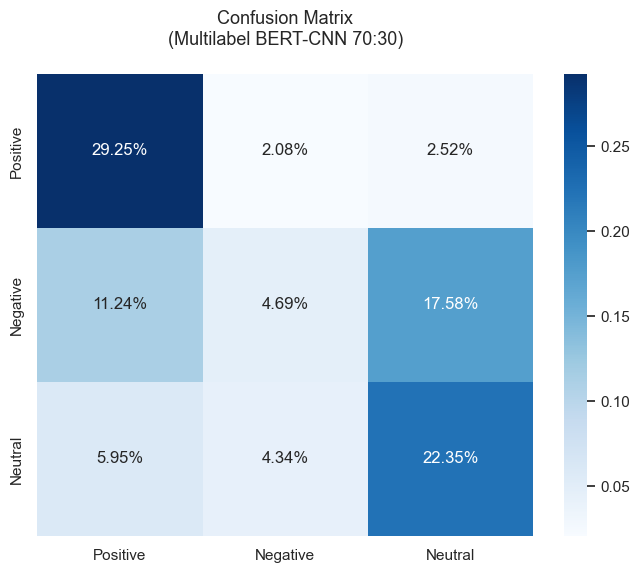

Epoch: 02

	Train Loss: 0.917
	Test Loss: 0.932

	Accuracy: 0.5816 | F1-Score: 0.5626
	Precision: 0.5601 | Recall: 0.5817

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6907    0.7872    0.7358       780
    Negative     0.4314    0.2811    0.3404       772
     Neutral     0.5581    0.6769    0.6118       752

    accuracy                         0.5816      2304
   macro avg     0.5601    0.5817    0.5626      2304
weighted avg     0.5605    0.5816    0.5628      2304


[[614 127  39]
 [191 217 364]
 [ 84 159 509]]


Epoch: 03

	Train Loss: 0.844
	Test Loss: 0.922

	Accuracy: 0.6046 | F1-Score: 0.5994
	Precision: 0.6015 | Recall: 0.6053

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7449    0.6962    0.7197       780
    Negative     0.4766    0.3964    0.4328       772
     Neutral     0.5831    0.7234    0.6457       752

    accuracy                         0.6046      2304
   macro avg     0.6015    0.6053    0.5994      2304
weighted avg     0.6022    0.6046    0.5994      2304


[[543 176  61]
 [138 306 328]
 [ 48 160 544]]


Epoch: 04

	Train Loss: 0.791
	Test Loss: 0.902

	Accuracy: 0.6415 | F1-Score: 0.6419
	Precision: 0.6496 | Recall: 0.6404

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7351    0.7577    0.7462       780
    Negative     0.5214    0.5984    0.5573       772
     Neutral     0.6922    0.5652    0.6223       752

    accuracy                         0.6415      2304
   macro avg     0.6496    0.6404    0.6419      2304
weighted avg     0.6495    0.6415    0.6425      2304


[[591 159  30]
 [151 462 159]
 [ 62 265 425]]


Epoch: 05

	Train Loss: 0.750
	Test Loss: 0.897

	Accuracy: 0.6467 | F1-Score: 0.6396
	Precision: 0.6416 | Recall: 0.6456

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6841    0.8385    0.7535       780
    Negative     0.5716    0.5013    0.5342       772
     Neutral     0.6692    0.5971    0.6311       752

    accuracy                         0.6467      2304
   macro avg     0.6416    0.6456    0.6396      2304
weighted avg     0.6415    0.6467    0.6400      2304


[[654  85  41]
 [204 387 181]
 [ 98 205 449]]


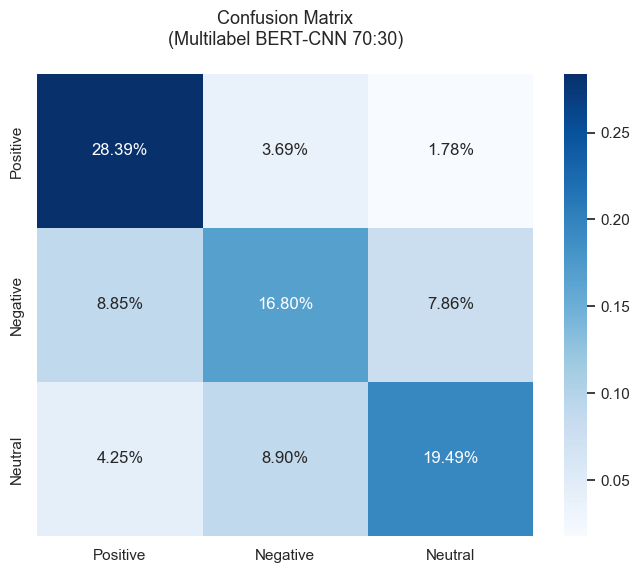

Epoch: 06

	Train Loss: 0.724
	Test Loss: 0.908

	Accuracy: 0.6311 | F1-Score: 0.6359
	Precision: 0.6488 | Recall: 0.6309

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7908    0.6590    0.7189       780
    Negative     0.5075    0.6166    0.5567       772
     Neutral     0.6480    0.6170    0.6322       752

    accuracy                         0.6311      2304
   macro avg     0.6488    0.6309    0.6359      2304
weighted avg     0.6493    0.6311    0.6362      2304


[[514 207  59]
 [103 476 193]
 [ 33 255 464]]


Epoch: 07

	Train Loss: 0.711
	Test Loss: 0.905

	Accuracy: 0.6367 | F1-Score: 0.6310
	Precision: 0.6359 | Recall: 0.6353

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6869    0.8269    0.7504       780
    Negative     0.5382    0.5298    0.5339       772
     Neutral     0.6826    0.5492    0.6087       752

    accuracy                         0.6367      2304
   macro avg     0.6359    0.6353    0.6310      2304
weighted avg     0.6357    0.6367    0.6316      2304


[[645 107  28]
 [199 409 164]
 [ 95 244 413]]


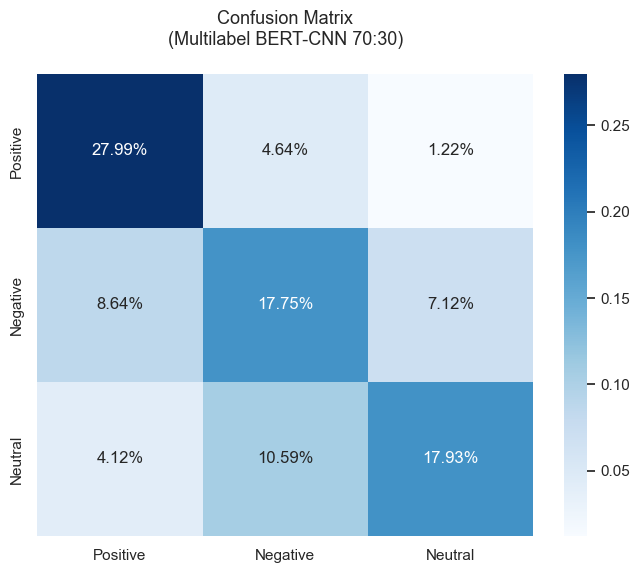

Epoch: 08

	Train Loss: 0.703
	Test Loss: 0.913

	Accuracy: 0.6250 | F1-Score: 0.6270
	Precision: 0.6326 | Recall: 0.6243

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7419    0.7077    0.7244       780
    Negative     0.5108    0.5829    0.5445       772
     Neutral     0.6451    0.5824    0.6122       752

    accuracy                         0.6250      2304
   macro avg     0.6326    0.6243    0.6270      2304
weighted avg     0.6329    0.6250    0.6275      2304


[[552 173  55]
 [136 450 186]
 [ 56 258 438]]


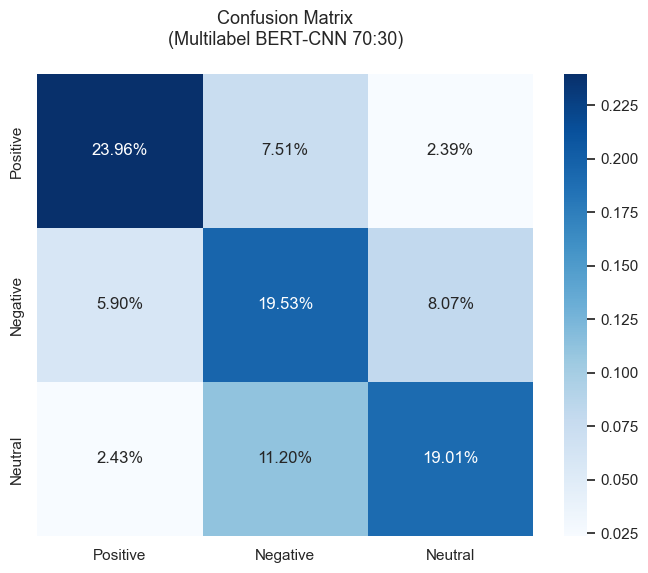

Epoch: 09

	Train Loss: 0.694
	Test Loss: 0.902

	Accuracy: 0.6428 | F1-Score: 0.6374
	Precision: 0.6411 | Recall: 0.6414

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6878    0.8192    0.7478       780
    Negative     0.5641    0.5531    0.5585       772
     Neutral     0.6715    0.5519    0.6058       752

    accuracy                         0.6428      2304
   macro avg     0.6411    0.6414    0.6374      2304
weighted avg     0.6410    0.6428    0.6381      2304


[[639 103  38]
 [180 427 165]
 [110 227 415]]


Epoch: 10

	Train Loss: 0.682
	Test Loss: 0.907

	Accuracy: 0.6324 | F1-Score: 0.6324
	Precision: 0.6332 | Recall: 0.6319

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7353    0.7372    0.7362       780
    Negative     0.5263    0.5440    0.5350       772
     Neutral     0.6381    0.6144    0.6260       752

    accuracy                         0.6324      2304
   macro avg     0.6332    0.6319    0.6324      2304
weighted avg     0.6336    0.6324    0.6328      2304


[[575 156  49]
 [139 420 213]
 [ 68 222 462]]


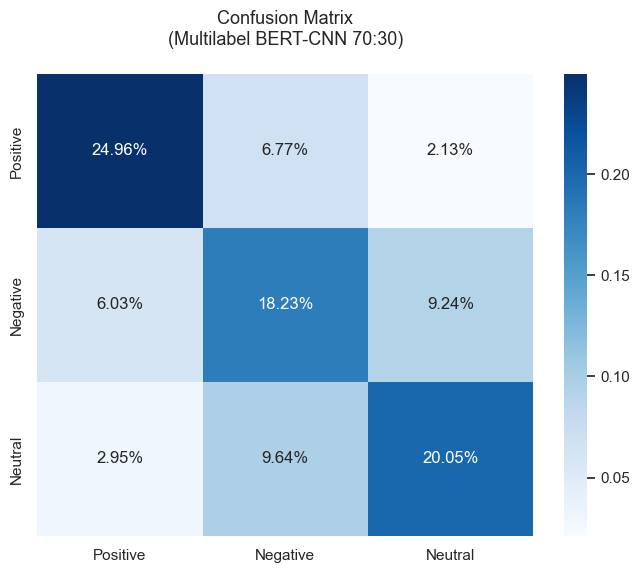

In [55]:
from sklearn.metrics import classification_report

N_EPOCHS = 10
predicted_sentiments_per_epoch = []
true_sentiments_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_sentiments, true_sentiments = evaluate(model, test_iterator)
    
    # Save the predicted_sentiments and true_sentiments for the current epoch
    predicted_sentiments_per_epoch.append(predicted_sentiments)
    true_sentiments_per_epoch.append(true_sentiments)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_sentiments, predicted_sentiments, target_names=['Positive', 'Negative', 'Neutral'], digits = 4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_sentiments, predicted_sentiments)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})  # Add a closing parenthesis to set
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Multilabel BERT-CNN 70:30)\n', fontsize=13)
    plt.show()